In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Defino algunos datos base del beam
fc = 28
E = 4700 * (fc**0.5)
A = 300 * 300
I = 300 * 300 ** 3 / 12

A = A * 100

In [ ]:
class Frame2DOffsets:

    def __init__ (self, coord_inicial, coord_final, E, A, I, printSummary = True, dx = 0, dy = 0):
        self.coord_i = coord_inicial
        self.coord_f = coord_final
        self.E = E
        self.A = A
        self.I = I

        self.dx = dx
        self.dy = dy

        self.L, self.angle = self._geometria()
        self.kb = self.stiffness_matrix_basic()
        self.Tbl = self.basicLocalTransformations()
        self.kl = self.localStiffnessMatrix()
        self.Tlg = self.localGlobalTransformation()
        self.kg = self.globalStiffnessMatrix()
        self.Ts = self.transformationStiffnessMatrix()
        self.indices = self._elementIndices()
        self.u_global, self.u_local, self.u_basic, self.u_corrected = None, None, None, None
        self.f_local = None
        self.f_basic = None


        if printSummary:
            self.printSummary()


    def _geometria(self):
        coord_i_real = self.coord_i.copy()
        coord_f_real = self.coord_f.copy()

        delta = coord_f_real - coord_i_real
        length_total = np.linalg.norm(delta)
        direction_unit = delta / length_total
        angle = np.arctan2(delta[1], delta[0])

        # Matriz de transformación local → global
        c = direction_unit[0]
        s = direction_unit[1]
        R = np.array([[c, -s],
                      [s,  c]])

        # Offsets locales independientes para cada nodo
        offset_i_local = np.array([self.dx, self.dy])      # nodo i
        offset_j_local = np.array([-self.dx, self.dy])     # nodo j (inverso en X local)

        # Transformarlos a coordenadas globales
        offset_i_global = R @ offset_i_local
        offset_j_global = R @ offset_j_local

        self.offset_i_global = offset_i_global
        self.offset_j_global = offset_j_global

        self.L_offset_i = np.linalg.norm(offset_i_global)
        self.L_offset_j = np.linalg.norm(offset_j_global)



        # Aplicar a los extremos
        coord_i_offset = coord_i_real + offset_i_global
        coord_f_offset = coord_f_real + offset_j_global

        # Guardar valores
        self.coord_i_offset = coord_i_offset
        self.coord_f_offset = coord_f_offset
        self.R = R
        self.angle = angle

        length_effective = np.linalg.norm(coord_f_offset - coord_i_offset)
        return length_effective, angle




    def stiffness_matrix_basic (self):
        L = self.L
        A = self.A
        E = self.E
        I = self.I

        Kb = np.array([[A*E/L, 0, 0],
                      [0, 4*E*I/L, 2*E*I/L],
                      [0, 2*E*I/L, 4*E*I/L]])

        return Kb

    def basicLocalTransformations (self):
        L = self.L * 1000
        Tbl = np.array([
            [-1, 0, 0, 1, 0, 0],
            [0, 1/L, 1, 0, -1/L, 0],
            [0, 1/L, 0, 0, -1/L, 1]
            ])
        return Tbl

    def localStiffnessMatrix (self):
        Tbl = self.Tbl
        Kb = self.kb

        Kl = Tbl.T @ Kb @ Tbl

        return Kl

    def localGlobalTransformation (self):
        c = np.cos(self.angle)
        s = np.sin(self.angle)

        Tlg = np.array([[ c, s, 0,  0, 0, 0],
                        [-s, c, 0,  0, 0, 0],
                        [ 0, 0, 1,  0, 0, 0],
                        [ 0, 0, 0,  c, s, 0],
                        [ 0, 0, 0, -s, c, 0],
                        [ 0, 0, 0,  0, 0, 1]
                        ])

        return Tlg

    def globalStiffnessMatrix (self):
        k = self.kl
        tlg = self.Tlg

        Kg = tlg.T @ k @ tlg

        return Kg

    def transformationStiffnessMatrix(self):
        # Offsets en coordenadas locales
        offset_i_local = np.array([self.dx, self.dy])     # Nodo i
        offset_j_local = np.array([-self.dx, self.dy])    # Nodo j (inverso en X local)

        # Transformación local → global
        offset_i_global = self.R @ offset_i_local
        offset_j_global = self.R @ offset_j_local

        dxi, dyi = offset_i_global
        dxj, dyj = offset_j_global

        Ts = np.array([
            [1, 0, -dyi, 0, 0,   0],
            [0, 1,  dxi, 0, 0,   0],
            [0, 0,    1, 0, 0,   0],
            [0, 0,    0, 1, 0, -dyj],  # ← sin cambio de signo
            [0, 0,    0, 0, 1,  dxj],  # ← sin cambio de signo
            [0, 0,    0, 0, 0,    1]
        ])

        return Ts





    def _elementIndices (self):
        return np.linspace(0, 5, 6, dtype=int)

    def _extractDisplacements (self, u):
      
        u_global = u
        
        Tlg = self.Tlg
        u_local = Tlg @ u_global
        Tbl = self.Tbl
        u_basic = Tbl @ u_local


        self.u_global = u_global
        self.u_local = u_local
        self.u_basic = u_basic

        # Calcular los extremos deformados del elemento útil
        _, p1i = self.offset_rigido_deformado(
            self.coord_i, u[0:3], self.offset_i_global
        )
        _, p1j = self.offset_rigido_deformado(
            self.coord_f, u[3:6], self.offset_j_global
        )

        # Guardar vector deformado como array de 2x2: [[xi, yi], [xf, yf]]
        self.u_corrected = np.array([p1i, p1j])

        return u_global, u_local, u_basic


    def _calculateLocalForces (self, u):
        _, u_local, _ = self._extractDisplacements(u)
        Kl = self.kl
        f_local = Kl @ u_local
        self.f_local = f_local

    def _calculateBasicForces (self, u):
        _, _, u_basic = self._extractDisplacements(u)
        Kb = self.kb
        f_basic = Kb @ u_basic
        self.f_basic = f_basic


    def forceRecorvery (self, u):
        self._calculateLocalForces(u)
        self._calculateBasicForces(u)
        pass

    def rotar_offset(self, offset_vec, theta):
        """
        Rota un vector de offset rígido según un ángulo theta (en radianes).
        """
        R_theta = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        return R_theta @ offset_vec

    def _offset_direction_unit(self, offset_global):
        return offset_global / np.linalg.norm(offset_global)

    def _extremo_rigido_deformado(self, nodo_real, u_nodo, offset_global):
        """
        Retorna los dos puntos del offset rígido deformado (inicio y final),
        considerando el desplazamiento y el giro del nodo.
        """
        escala = 1.0  # lo ajustas externamente si necesitas
        u_trasl = u_nodo[0:2] * escala
        theta = u_nodo[2]

        p0 = nodo_real + u_trasl  # nodo deformado

        # Vector de offset rotado con el giro del nodo
        offset_rotado = self.rotar_offset(offset_global, theta) * escala

        p1 = p0 + offset_rotado
        return p0, p1

    def offset_rigido_deformado(self, nodo_real, u_nodo, offset_global):
        """
        Devuelve los dos puntos que definen el offset rígido deformado:
        desde el nodo deformado hasta el inicio del elemento útil.
        """
        ux, uy, theta = u_nodo
        p_deformado = nodo_real + np.array([ux, uy])

        # Rotación del offset alrededor del nodo
        R_theta = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        offset_rotado = R_theta @ offset_global

        p_final = p_deformado + offset_rotado
        return p_deformado, p_final






    def plotGeometry(self, ax=None, text=False, nodes=True, nodes_labels=False, deformada=True, escala=1):

        if ax is None:
            fig, ax = plt.subplots()

        # Coordenadas reales (nodos)
        xi_real, yi_real = self.coord_i
        xf_real, yf_real = self.coord_f

        # Coordenadas con offset (barra útil)
        xi, yi = self.coord_i_offset
        xf, yf = self.coord_f_offset

        # 1. Eje total entre nodos reales
        ax.plot([xi_real, xf_real], [yi_real, yf_real], 'k--', linewidth=1, label='Eje total (entre nodos)')

        # 2. Offsets rígidos
        ax.plot([xi_real, xi], [yi_real, yi], color='orange', linewidth=3, label='Offset rígido')
        ax.plot([xf, xf_real], [yf, yf_real], color='orange', linewidth=3)

        # 3. Elemento útil (sin deformación)
        ax.plot([xi, xf], [yi, yf], 'b-', linewidth=2, label='Elemento útil')

        # 4. Nodos reales
        if nodes:
            ax.plot(xi_real, yi_real, 'ro')
            ax.plot(xf_real, yf_real, 'ro')

        # 5. Etiquetas de nodo
        if nodes_labels:
            ax.text(xi_real, yi_real, f"i ({xi_real:.2f}, {yi_real:.2f})", fontsize=9, ha='right', va='bottom')
            ax.text(xf_real, yf_real, f"f ({xf_real:.2f}, {yf_real:.2f})", fontsize=9, ha='left', va='top')

        # 6. Texto del largo
        if text:
            xm = (xi + xf) / 2
            ym = (yi + yf) / 2
            ax.text(xm, ym, f"L útil = {self.L:.2f} m", fontsize=10, color='darkgreen', ha='center')

            # 7. Dibujar deformada interpolada
        if deformada and self.u_global is not None:
            u_global = self.u_global.flatten()

            # Transformar a coordenadas locales
            u_local = self.Tlg @ (self.Ts @ u_global)

            # Extraer grados de libertad locales
            ui_x, ui_y, theta_i, uj_x, uj_y, theta_j = u_local

            # Coordenadas locales a lo largo del eje
            L = self.L
            n_points = 50
            x_vals = np.linspace(0, L, n_points)

            # Interpolación en X (axial)
            u_x_vals = (1 - x_vals / L) * ui_x + (x_vals / L) * uj_x

            # Funciones de forma para flexión (en Y)
            def N1(x): return 1 - 3*(x/L)**2 + 2*(x/L)**3
            def N2(x): return x*(1 - x/L)**2
            def N3(x): return 3*(x/L)**2 - 2*(x/L)**3
            def N4(x): return -x*(x/L)*(1 - x/L)

            v_vals = [N1(x)*ui_y + N2(x)*theta_i*L + N3(x)*uj_y + N4(x)*theta_j*L for x in x_vals]

            # Puntos locales deformados (X + Y interpolado)
            points_local = np.vstack([u_x_vals, v_vals]) * escala + np.vstack([x_vals, np.zeros_like(x_vals)])

            # Transformar a coordenadas globales
            points_global = self.R @ points_local

            # Trasladar al sistema global real
            x0, y0 = self.coord_i_offset
            x_def = points_global[0, :] + x0
            y_def = points_global[1, :] + y0

            ax.plot(x_def, y_def, 'r--', linewidth=2, label=f'Deformada (x{escala})')


            # --- EXTREMOS RÍGIDOS DEFORMADOS ---

            # Escala
            escala = escala

            # Nodo i
            p0i, p1i = self.offset_rigido_deformado(self.coord_i, u_global[0:3]*escala, self.offset_i_global*escala)
            ax.plot([p0i[0], p1i[0]], [p0i[1], p1i[1]], 'r--', linewidth=3)

            # Nodo j
            p0j, p1j = self.offset_rigido_deformado(self.coord_f, u_global[3:6]*escala, self.offset_j_global*escala)
            ax.plot([p0j[0], p1j[0]], [p0j[1], p1j[1]], 'r--', linewidth=3)

        ax.set_aspect('equal')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(True)
        # Mueve la leyenda fuera del gráfico, al lado derecho
        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)


        if ax is None:
            plt.show()



    def printSummary (self):
        print(f'\nCoordenada inicial {self.coord_i}')
        print(f'\nCoordenada final {self.coord_f}')
        print(f'\nE = {self.E}')
        print(f'\nA = {self.A}')
        print(f'\nI = {self.I}')
        print(f'\nLargo = {self.L}')
        print(f'\nangle = {self.angle}')
        print(f'\nkb = {self.kb}')
        print(f'\nTbl = {self.Tbl}')
        print(f'\nkl = {self.kl}')
        print(f'\nTlg = {self.Tlg}')
        print(f'\nkg = {self.kg}')
        print(f'\nindices = {self.indices}')
        print(f'\nu_global = {self.u_global}')
        print(f'\nu_local = {self.u_local}')
        print(f'\nu_basic = {self.u_basic}')
        print(f'\nf_local = {self.f_local}')
        print(f'\nf_basic = {self.f_basic}')
        print(f'\nNodos que concetan los elementos rigidos = {self.u_corrected}')
#


### Caso de estudio 1 – Viga simple sin offsets rígidos

**Geometría del elemento**  
- Nodo inicial: `(0, 0)`  
- Nodo final: `(3, 0)`  
- Sin offsets rígidos

**Condiciones de desplazamiento impuestas**
- Desplazamiento vertical nodo inicial (`x₁`) = **+1.0**    
- Desplazamiento vertical nodo inicial (`y₁`) = **+1.0**  
- Desplazamiento vertical nodo final (`y₂`) = **−1.0**

**Visualización esperada**  
- Deformación simétrica hacia arriba y hacia abajo
- El eje original de la viga es horizontal
- El nodo de la izquierda se debe desplzar 1 horizontalmente



Coordenada inicial [0. 0.]

Coordenada final [3. 0.]

E = 24870.062324007155

A = 9000000

I = 675000000.0

Largo = 3.0

angle = 0.0

kb = [[7.46101870e+10 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.23830561e+13 1.11915280e+13]
 [0.00000000e+00 1.11915280e+13 2.23830561e+13]]

Tbl = [[-1.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-04  1.00000000e+00  0.00000000e+00
  -3.33333333e-04  0.00000000e+00]
 [ 0.00000000e+00  3.33333333e-04  0.00000000e+00  0.00000000e+00
  -3.33333333e-04  1.00000000e+00]]

kl = [[ 7.46101870e+10  0.00000000e+00  0.00000000e+00 -7.46101870e+10
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  7.46101870e+06  1.11915280e+10  0.00000000e+00
  -7.46101870e+06  1.11915280e+10]
 [ 0.00000000e+00  1.11915280e+10  2.23830561e+13  0.00000000e+00
  -1.11915280e+10  1.11915280e+13]
 [-7.46101870e+10  0.00000000e+00  0.00000000e+00  7.46101870e+10
   0.00000000e+00  0.00000000

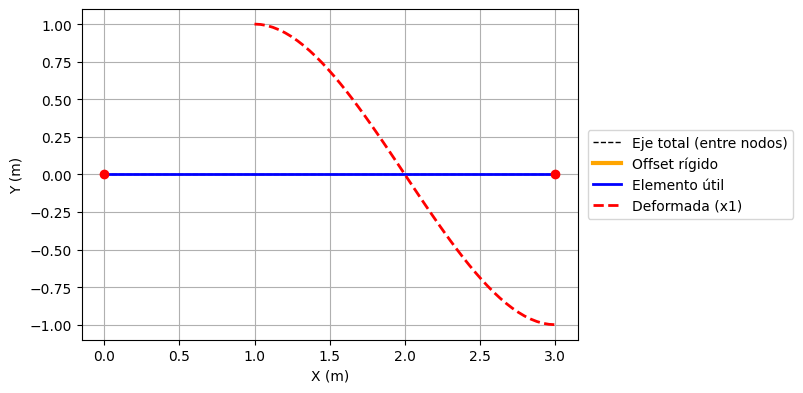

In [ ]:
beam = Frame2DOffsets(np.array([0.0, 0.0]), np.array([3.0, 0.0]), E, A, I, False)

u = np.array([1,1,0,0,-1,0])

K = beam.Ts.T @ beam.kg @ beam.Ts

F = K @ u

beam._extractDisplacements(u)

beam.forceRecorvery(u)

beam.printSummary()

beam.plotGeometry(text=False, nodes=True, nodes_labels=False)


Se puede observar que el empotramiento se mantiene correctamente, además los desplazamientos con la función de forma se implementan correctamente.

### Caso de estudio 2 – Viga con offsets rígidos

**Geometría del elemento**  
- Nodo inicial: (0.0, 0.0)  
- Nodo final: (3.0, 0.0)  
- Offsets rígidos en ambos extremos: (0.5, 0.5)

**Condiciones de desplazamiento impuestas**  
- No se aplican desplazamientos ni giros

**Objetivo**  
Observar el efecto geométrico de los offsets rígidos en la forma del elemento, manteniendo la estructura en reposo.



Coordenada inicial [0. 0.]

Coordenada final [3. 0.]

E = 24870.062324007155

A = 9000000

I = 675000000.0

Largo = 2.0

angle = 0.0

kb = [[1.11915280e+11 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.35745841e+13 1.67872921e+13]
 [0.00000000e+00 1.67872921e+13 3.35745841e+13]]

Tbl = [[-1.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00]
 [ 0.e+00  5.e-04  1.e+00  0.e+00 -5.e-04  0.e+00]
 [ 0.e+00  5.e-04  0.e+00  0.e+00 -5.e-04  1.e+00]]

kl = [[ 1.11915280e+11  0.00000000e+00  0.00000000e+00 -1.11915280e+11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.51809381e+07  2.51809381e+10  0.00000000e+00
  -2.51809381e+07  2.51809381e+10]
 [ 0.00000000e+00  2.51809381e+10  3.35745841e+13  0.00000000e+00
  -2.51809381e+10  1.67872921e+13]
 [-1.11915280e+11  0.00000000e+00  0.00000000e+00  1.11915280e+11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.51809381e+07 -2.51809381e+10  0.00000000e+00
   2.51809381e+07 -2.51809381e+10]
 [ 0.00000000e+00  2.51809381e+10  1.678729

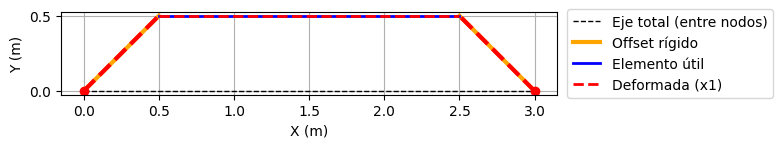

In [ ]:
beam = Frame2DOffsets(np.array([0.0, 0.0]), np.array([3.0, 0.0]), E, A, I, False, dx = 0.5, dy = 0.5)

u = np.array([0,0,0,0,0,0])

K = beam.Ts.T @ beam.kg @ beam.Ts

F = K @ u

beam._extractDisplacements(u)

beam.forceRecorvery(u)

beam.printSummary()

beam.plotGeometry(text=False, nodes=True, nodes_labels=False)

Se puede observar que la deformada tiene la misma forma que la viga inicial, lo cual es correcto. Adicionalmente, se pueden notar los offsets rígidos, los cuales se implementaron de forma simétrica en el código. De esta forma, si dx es positivo, las coordenadas en x se recortarán igualmente, al igual que en y.

### Caso de estudio 3 – Viga con offsets rígidos y desplazamiento en nodo inicial

**Geometría del elemento**  
- Nodo inicial: (0.0, 0.0)  
- Nodo final: (3.0, 0.0)  
- Offsets rígidos: (0.5, 0.5) en ambos extremos

**Condiciones de desplazamiento impuestas**  
- Nodo inicial: desplazamiento vertical y₁ = 1.0  
- Nodo final: sin desplazamientos ni giros

**Objetivo**  
Analizar la deformación del elemento bajo desplazamiento en un solo nodo, manteniendo los extremos rígidos simétricos.



Coordenada inicial [0. 0.]

Coordenada final [3. 0.]

E = 24870.062324007155

A = 9000000

I = 675000000.0

Largo = 2.0

angle = 0.0

kb = [[1.11915280e+11 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.35745841e+13 1.67872921e+13]
 [0.00000000e+00 1.67872921e+13 3.35745841e+13]]

Tbl = [[-1.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00]
 [ 0.e+00  5.e-04  1.e+00  0.e+00 -5.e-04  0.e+00]
 [ 0.e+00  5.e-04  0.e+00  0.e+00 -5.e-04  1.e+00]]

kl = [[ 1.11915280e+11  0.00000000e+00  0.00000000e+00 -1.11915280e+11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.51809381e+07  2.51809381e+10  0.00000000e+00
  -2.51809381e+07  2.51809381e+10]
 [ 0.00000000e+00  2.51809381e+10  3.35745841e+13  0.00000000e+00
  -2.51809381e+10  1.67872921e+13]
 [-1.11915280e+11  0.00000000e+00  0.00000000e+00  1.11915280e+11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.51809381e+07 -2.51809381e+10  0.00000000e+00
   2.51809381e+07 -2.51809381e+10]
 [ 0.00000000e+00  2.51809381e+10  1.678729

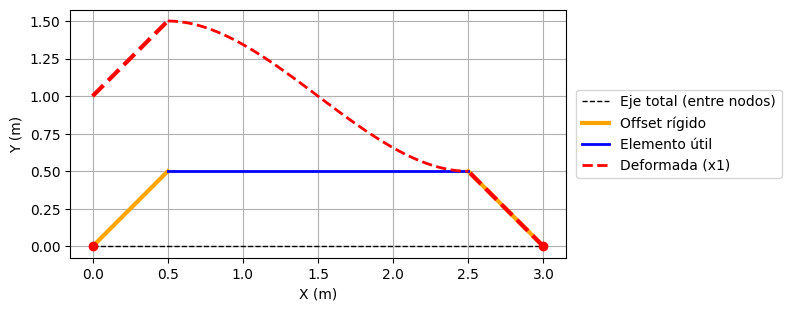

In [ ]:
beam = Frame2DOffsets(np.array([0.0, 0.0]), np.array([3.0, 0.0]), E, A, I, False, dx = 0.5, dy = 0.5)

u = np.array([0,1,0,0,0,0])

K = beam.Ts.T @ beam.kg @ beam.Ts

F = K @ u

beam._extractDisplacements(u)

beam.forceRecorvery(u)

beam.printSummary()

beam.plotGeometry(text=False, nodes=True, nodes_labels=False)

Se puede observar que con el desplazamiento = 1, todo el offset izquierdo se desplaza 1 hacia arriba. Además, se mantiene la condición de empotramiento.

### Caso de estudio 4 – Viga con desplazamiento y giro en el nodo inicial

**Geometría del elemento**  
- Nodo inicial: (0.0, 0.0)  
- Nodo final: (3.0, 0.0)  
- Offsets rígidos: (0.5, 0.5) en ambos extremos

**Condiciones de desplazamiento impuestas**  
- Nodo inicial:  
  - Desplazamiento vertical y₁ = 1.0  
  - Giro θ₁ ≠ 0  
- Nodo final: sin desplazamientos ni giros

**Objetivo**  
Evaluar el efecto de la rotación en el nodo izquierdo, junto al desplazamiento vertical, en la forma deformada del elemento.



Coordenada inicial [0. 0.]

Coordenada final [3. 0.]

E = 24870.062324007155

A = 9000000

I = 675000000.0

Largo = 2.0

angle = 0.0

kb = [[1.11915280e+11 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.35745841e+13 1.67872921e+13]
 [0.00000000e+00 1.67872921e+13 3.35745841e+13]]

Tbl = [[-1.e+00  0.e+00  0.e+00  1.e+00  0.e+00  0.e+00]
 [ 0.e+00  5.e-04  1.e+00  0.e+00 -5.e-04  0.e+00]
 [ 0.e+00  5.e-04  0.e+00  0.e+00 -5.e-04  1.e+00]]

kl = [[ 1.11915280e+11  0.00000000e+00  0.00000000e+00 -1.11915280e+11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.51809381e+07  2.51809381e+10  0.00000000e+00
  -2.51809381e+07  2.51809381e+10]
 [ 0.00000000e+00  2.51809381e+10  3.35745841e+13  0.00000000e+00
  -2.51809381e+10  1.67872921e+13]
 [-1.11915280e+11  0.00000000e+00  0.00000000e+00  1.11915280e+11
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.51809381e+07 -2.51809381e+10  0.00000000e+00
   2.51809381e+07 -2.51809381e+10]
 [ 0.00000000e+00  2.51809381e+10  1.678729

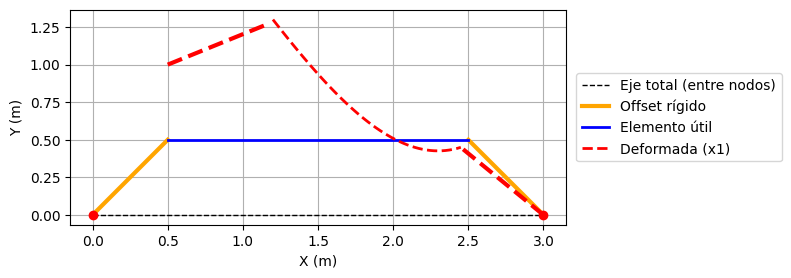

In [ ]:
beam = Frame2DOffsets(np.array([0.0, 0.0]), np.array([3.0, 0.0]), E, A, I, False, dx = 0.5, dy = 0.5)

u = np.array([0.5,1, -0.4,0,0,0.1])

K = beam.Ts.T @ beam.kg @ beam.Ts

F = K @ u

beam._extractDisplacements(u)

beam.forceRecorvery(u)

beam.printSummary()

beam.plotGeometry(text=False, nodes=True, nodes_labels=False)

Se puede observar que los elementos rígidos mantienen la condición de rigidez y de los apoyos del cuerpo.
